# 8-1.프로젝트 : CIFAR-10 이미지 생성하기

### STEP 1. 작업환경 구성하기

In [125]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)
print("imageio", imageio.__version__)

tensorflow 2.6.0
imageio 2.9.0


### STEP 2. 데이터셋 구성하기

In [126]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
train_x.shape

(50000, 32, 32, 3)

In [127]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [128]:
# float 변환 및 정규화
train_x = train_x.astype('float32')
print("Before normalization:", train_x[0].min(), train_x[0].max())  # 이때는 0~255일 것

train_x = (train_x - 127.5) / 127.5
print("After normalization:", train_x[0].min(), train_x[0].max())  # 이제는 -1~1 근처

train_x = train_x.reshape(-1, 32, 32, 3)

Before normalization: 0.0 255.0
After normalization: -1.0 1.0


In [129]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_x.shape

(50000, 32, 32, 3)

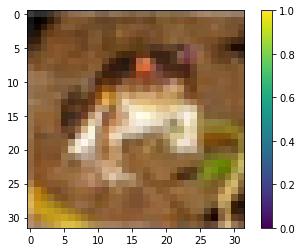

In [130]:
plt.imshow((train_x[0] + 1) / 2)
plt.colorbar()
plt.show()

### STEP 3. 생성자 모델 구현하기

In [131]:

def make_generator_model():
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,))) # (7*7*256)수정, 28 > 32
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256))) # (7*7*256)수정, 28 > 32

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer (Output)
    model.add(layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh'))
    # 1 > 3 으로 수정
    
    return model


In [132]:
generator = make_generator_model()
generator.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_12 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 8, 8, 128)       

In [133]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

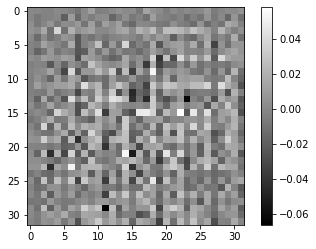

In [134]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

### STEP 4. 판별자 모델 구현하기

In [135]:

def make_discriminator_model():
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    # filters=64, kernel_size=5, strides=2, padding='same', input_shape=(32, 32, 3)
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same',
                            input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    # filters=128, kernel_size=5, strides=2, padding='same'
    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))  # 판별자 출력 (진짜/가짜 여부)

    return model


In [136]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)            

In [137]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00452628]], dtype=float32)>

### STEP 5. 손실함수와 최적화 함수 구현하기

- 손실함수(loss function)

In [138]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [139]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [140]:
def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    return total_loss

In [141]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

- 최적화 함수(optimizer)

In [142]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### STEP 6. 훈련과정 상세 기능 구현하기

In [143]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값


In [144]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [145]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [146]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### STEP 7. 학습 과정 진행하기

In [147]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [148]:
save_every = 5
EPOCHS = 50  # 학습을 50번 반복한다고 설정 (다른 값으로 조정 가능)

# 사용 가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

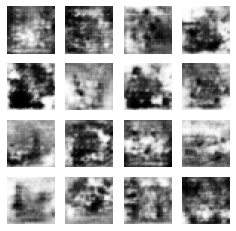

Time for training : 947 sec


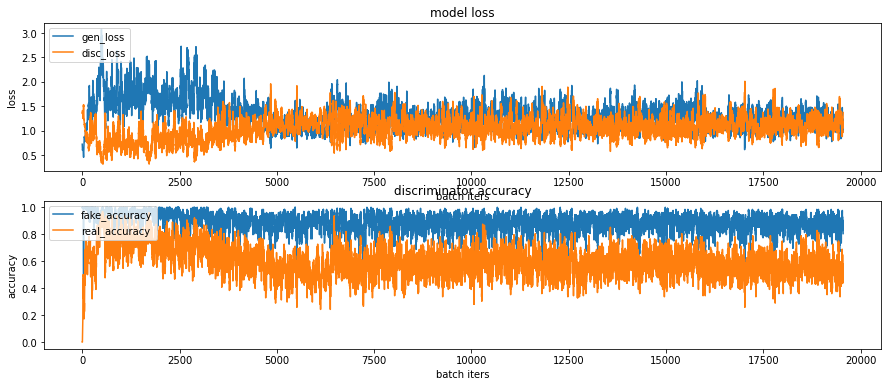

CPU times: user 10min 28s, sys: 1min 48s, total: 12min 16s
Wall time: 15min 49s


In [149]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있어
# 진행 과정을 수시로 확인 가능

In [150]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1815328 Apr 16 11:10 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


In [154]:
# generator는 이미 학습 완료된 모델이라고 가정
generator.save('generator.h5')

### 1. 훈련과정의 loss, accuracy로 확인

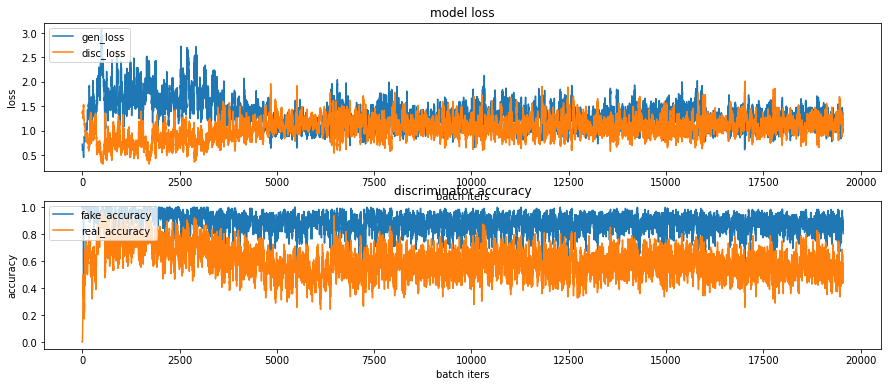

##### 🔷 위쪽 그래프: 손실 함수 (Loss)
- 파란색 (gen_loss):
> 생성자의 손실.
<br>
> 값이 높으면 판별자가 가짜를 잘 구분하고 있다는 뜻이고, 값이 낮아지면 생성자가 진짜 같은 이미지를 잘 만들고 있다는 의미

- 주황색 (disc_loss):
> 판별자의 손실.
<br>
> 값이 낮을수록 진짜/가짜를 잘 구별하고 있다는 뜻이고, 값이 높으면 판별이 어려워졌다는 의미

- 해석:
> 초반에는 두 손실 모두 요동치다가, 시간이 지날수록 disc_loss는 낮아지고, gen_loss는 점차 증가
<br>
> 이는 판별자가 어느 정도 진짜/가짜를 구분하는 능력이 안정되었지만, 생성자는 점점 더 어려운 싸움을 하고 있다는 신호로 볼 수 있음

- 일반적인 GAN 훈련에서 흔히 보는 패턴

##### 🟠 아래쪽 그래프: 판별자의 정확도 (Accuracy)
- 파란색 (fake_accuracy)
> 가짜 이미지를 "가짜"라고 맞춘 비율 (판별자의 정확도)

- 주황색 (real_accuracy):
> 진짜 이미지를 "진짜"라고 맞춘 비율

- 해석:
> 초반에는 정확도가 들쭉날쭉하지만, 후반으로 갈수록 fake_accuracy는 높고, real_accuracy는 다소 낮아짐을 볼 수 있음
<br>
> 즉, 판별자는 가짜는 잘 잡아내지만, 진짜를 진짜로 판별하는 데 약간 헷갈려하는 상황
<br>
> 이런 현상은 생성자가 점점 더 진짜 같은 이미지를 생성하고 있다는 징후일 수 있습니다.

### 2. 훈련 결과를 FID 지표로 확인

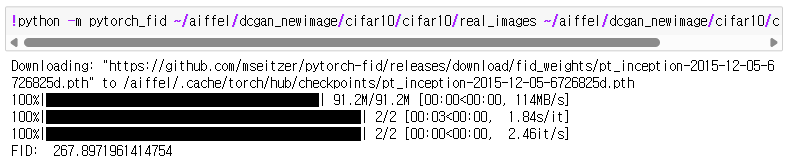

- 현재 점수 267.9는 진짜 이미지와 분포가 많이 다르다는 것을 의미
- 즉, 생성된 이미지들이 CIFAR-10 이미지처럼 보이지 않거나, 다양성이 매우 부족할 수 있음

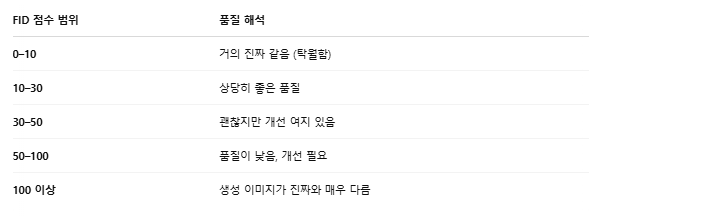

- 예상 원인
1. 학습 epoch 수가 부족하거나 불안정
2. mode collapse: 비슷한 이미지만 반복 생성
3. 생성자(Generator) 구조가 너무 단순
4. 노이즈 다양성이 부족하거나 학습률이 안 맞음
5. 판별자(Discriminator)가 너무 강해서 생성자가 못 따라감

> 판별자는 유지하고 생성자를 개선
> 생성자 구조를 개선을 먼저 수행 후, epoch, learning rate 등 수치 조절하기로 함

### STEP 8. (optional) GAN 훈련 과정 개선하기

##### 개선 아이디어 1: 생성자 모델에 Dropout 추가로 더 다양하고 안정적인 이미지 생성

##### 개선 아이디어 2: Residual Block을 도입한 Generator로 구조 변경
- ResNet-like 구조를 generator에 도입하여 더 부드러운 이미지 생성

##### 개선 아이디어 3: 학습 전략 개선
- 학습률 감소: Adam(1e-4) → Adam(1e-5) : 1차 개선 결과 확인 후 적용 여부 검토

In [27]:
from tensorflow.keras.models import load_model
generator = load_model('generator.h5')

In [28]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)
print("imageio", imageio.__version__)

tensorflow 2.6.0
imageio 2.9.0


In [29]:
# ▶ CIFAR-10 data loading
(train_x, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_x = train_x.astype('float32')
train_x = (train_x - 127.5) / 127.5  # Normalize to [-1, 1]
train_x = train_x.reshape(-1, 32, 32, 3)

BUFFER_SIZE = 50000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [30]:
# ▶ Custom Residual Block : 정보 흐름 보존, 더 선명한 이미지 가능
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.conv1 = layers.Conv2D(filters, 3, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.conv2 = layers.Conv2D(filters, 3, padding='same', use_bias=False)
        self.bn2 = layers.BatchNormalization()

    def call(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        return self.relu(x + shortcut)

    def get_config(self):
        config = super().get_config()
        config.update({"filters": self.filters})
        return config

In [31]:
# ▶ Generator with Dropout + Residual Block : 과적합 방지, 이미지 다양성 증가
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))

    model.add(layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(ResidualBlock(128))

    model.add(layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(ResidualBlock(64))

    model.add(layers.Conv2DTranspose(3, 5, strides=2, padding='same', use_bias=False, activation='tanh'))
    return model


In [32]:
# ▶ Discriminator : 현재 상태 유지
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, 5, strides=2, padding='same', input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, 5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [33]:
# ▶ Loss and Optimizer
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(real_output >= 0.5, tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(fake_output < 0.5, tf.float32))
    return real_accuracy, fake_accuracy


In [34]:
generator = make_generator_model()
discriminator = make_discriminator_model()

# learning rate는 유지
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [35]:
generator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_18 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_19 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)        

In [36]:
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

In [37]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        real_acc, fake_acc = discriminator_accuracy(real_output, fake_output)

    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_acc, fake_acc

In [45]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)
    predictions = (predictions + 1) / 2  # restore [0, 1] range
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')
    plt.savefig(f'{os.getenv("HOME")}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{epoch:04d}_iter_{it:03d}.png')
    plt.show()

In [47]:
def draw_train_history(history, epoch):
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('Loss')
    plt.legend(['Gen', 'Disc'])

    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('Discriminator Accuracy')
    plt.legend(['Fake', 'Real'])

    plt.savefig(f'{os.getenv("HOME")}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{epoch:04d}.png')
    plt.show()

In [40]:
checkpoint_dir = os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/training_checkpoints_balanced'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [41]:
def train(dataset, epochs, save_every):
    history = {'gen_loss': [], 'disc_loss': [], 'real_accuracy': [], 'fake_accuracy': []}
    for epoch in range(epochs):
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_acc, fake_acc = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_acc)
            history['fake_accuracy'].append(fake_acc)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch + 1, it + 1, seed)

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        generate_and_save_images(generator, epoch + 1, it + 1, seed)
        draw_train_history(history, epoch)

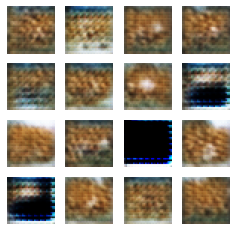

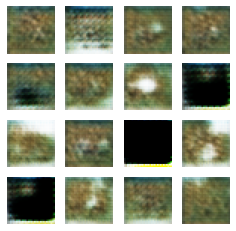

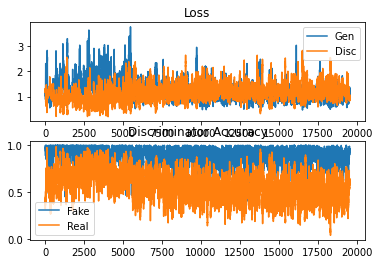

In [48]:
# ▶ 실행 예시 (학습)
EPOCHS = 50
save_every = 5

train(train_dataset, EPOCHS, save_every)

In [56]:
import imageio
import glob
import os

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_balanced.gif'
last = -1
last_filename = None

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_balanced/balanced*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
            image = imageio.imread(filename)
            writer.append_data(image)
            last_filename = filename

    # 마지막 이미지 한 번 더 추가
    if last_filename:
        image = imageio.imread(last_filename)
        writer.append_data(image)

# 확인
!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_balanced.gif


-rw-r--r-- 1 root root 1 Apr 17 07:30 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_balanced.gif


In [57]:
generator.save('generator_residual.h5')

##### FID 지표로 확인하기

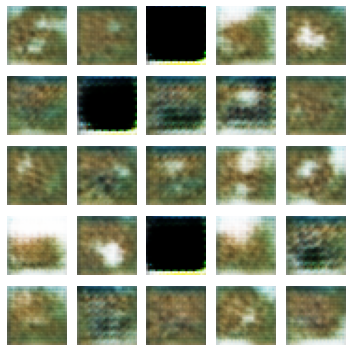

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def show_cifar10_generated_images(model, num_images=25, noise_dim=100):
    noise = tf.random.normal([num_images, noise_dim])
    generated_images = model(noise, training=False)
    generated_images = (generated_images + 1) / 2.0  # [-1, 1] → [0, 1] 정규화 해제

    plt.figure(figsize=(5, 5))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 사용 예시
show_cifar10_generated_images(generator, num_images=25)

In [59]:
import os
from PIL import Image

def save_cifar10_fake_residual(model, folder_path, num_images=100, noise_dim=100):
    os.makedirs(folder_path, exist_ok=True)
    noise = tf.random.normal([num_images, noise_dim])
    generated = model(noise, training=False)
    generated = (generated + 1) * 127.5  # [-1, 1] → [0, 255]
    generated = tf.cast(generated, tf.uint8).numpy()

    for i in range(num_images):
        img = Image.fromarray(generated[i])  # RGB
        img.save(os.path.join(folder_path, f"{i}.png"))

# 사용 예시
save_cifar10_fake_residual(generator, "cifar10/fake_residual", num_images=100)

In [60]:
import os
from PIL import Image
import tensorflow as tf

# CIFAR-10 불러오기
(train_x, _), (_, _) = tf.keras.datasets.cifar10.load_data()

# 저장할 폴더 경로
real_residual_dir = './cifar10/real_residual'
os.makedirs(real_residual_dir, exist_ok=True)

for i in range(100):
    img = Image.fromarray(train_x[i])  # RGB 이미지
    img.save(os.path.join(real_residual_dir, f"{i}.png"))



In [61]:
import os
from PIL import Image
import tensorflow as tf

def save_images_to_folder(model, folder_path, num_images=100, noise_dim=100):
    os.makedirs(folder_path, exist_ok=True)
    noise = tf.random.normal([num_images, noise_dim])
    generated = model(noise, training=False)
    generated = (generated + 1) * 127.5  # [-1, 1] → [0, 255]
    generated = tf.cast(generated, tf.uint8).numpy()

    for i in range(num_images):
        img = Image.fromarray(generated[i])  # RGB 저장 (자동으로 3채널 인식)
        img.save(os.path.join(folder_path, f"{i}.png"))

# 사용 예시
save_images_to_folder(generator, "cifar10/fake_residual")

In [63]:
real_residual_dir = os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/cifar10/real_residual')
fake_residual_dir = os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/cifar10/fake_residual')

print("Real Images (residual):", len(os.listdir(real_residual_dir)))
print("Fake Images (residual):", len(os.listdir(fake_residual_dir)))


Real Images (residual): 100
Fake Images (residual): 100


In [64]:
!pip install pytorch-fid

In [65]:
!python -m pytorch_fid ~/aiffel/dcgan_newimage/cifar10/cifar10/real_images ~/aiffel/dcgan_newimage/cifar10/cifar10/fake_images

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.16it/s]
FID:  261.43719879402374


### 1. 훈련과정의 loss, accuracy로 비교

> 1차 훈련
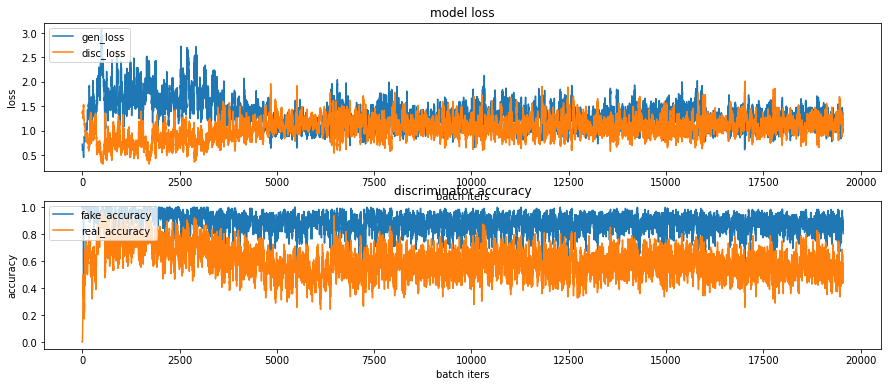

> 2차 훈련
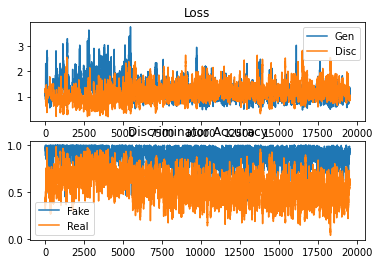

> 두 번째 훈련 결과(Residual + Dropout 추가)는 학습이 아주 약간 안정
<br>
> Generator는 판별자를 조금 더 잘 속일 수 있게 되었음.
<br>
> Discriminator는 혼란을 겪고 있음 → 이는 훈련이 아주 약간 잘 되고 있다는 신호

### 2. 훈련 결과를 FID 지표로 비교

> 1차 훈련
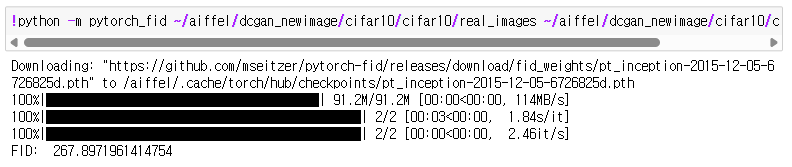

> 2차 훈련
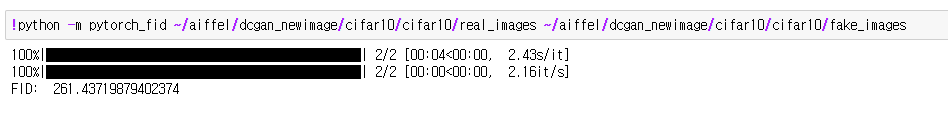

> 257.897에서 261.437로 약 6.4 정도 개선되었음